In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from datetime import datetime
import os
import time
import scipy.ndimage as ndi
import os
import imageio

# Multidimensional data

Although some images are very simple - either three or four band RGBxes  - or even single band (like DEMs), some images have substantially more bands, like [Landsat data](https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites).  Even those, though, will often just be distributed as multi-band GeoTIFFs.  Highly multidimensional data will generally be distributed in a different kind of container altogether.  Several of these are popular, including [NetCDF](https://www.unidata.ucar.edu/software/netcdf/), [HDF5](https://en.wikipedia.org/wiki/Hierarchical_Data_Format), [zarr](https://zarr.readthedocs.io/en/stable/), [GRIB](https://en.wikipedia.org/wiki/GRIB), and Esri's [Cloud Raster Format (CRF)](https://pro.arcgis.com/en/pro-app/latest/help/data/imagery/an-overview-of-multidimensional-raster-data.htm).

All of this multidimensional data can be read into Python, but before doing so, it might be helpful to see what this kind of data might be useful for, and how to visualize it.  We'll start with a simple Java viewer built by NASA to read NetCDFs and other multidimensional datasets called [Panoply](https://www.giss.nasa.gov/tools/panoply/).  One of the primary applications for NetCDFs is as a repository for meterological data, much of which needed to be logged at high-frequency time intervals.  Daily values (high, low, precipitation, etc.) need to be recorded over national and global scales.  To store this much data in image files would get unweidly, and even multi-band rasters with hundreds or thousands of bands are similarly dispreferred.

So let's start with some convenient NetCDF data from NOAA at https://downloads.psl.noaa.gov/Datasets/gpcc/full_v7/.  This dataset contains global precipitation estimates every year from 1900 to (almost) present.  Download the [2.5 degree precip totals](https://downloads.psl.noaa.gov/Datasets/gpcc/full_v7/precip.mon.total.2.5x2.5.v7.nc).  This is a 54 MB file.  Open it in Panoply, and visualize it.  Use the box to choose any particular year.  Panoply is a great way to quickly browse NetCDF data.

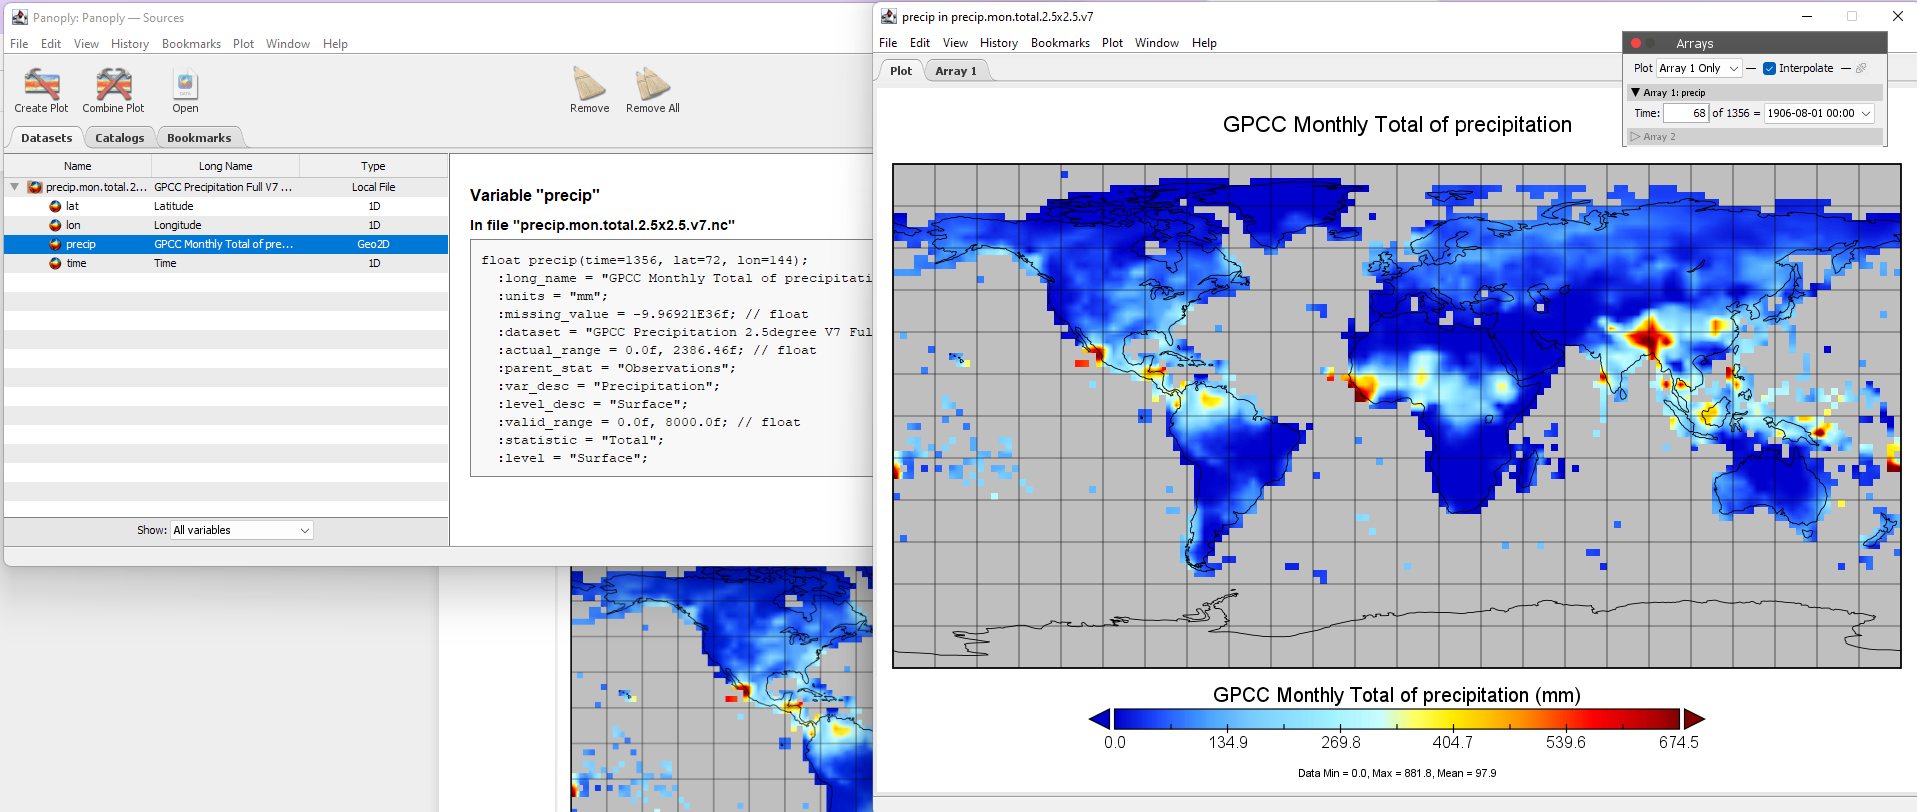

# Xarray and Rioxarray

[xarray](https://docs.xarray.dev/en/stable/) is used to read NetCDF files, and [rioxarray](https://corteva.github.io/rioxarray/stable/) adds support for rasterio to go between image and multidimensional data.  In addition to the Python packages, you'll probably want to install the NetCDF4 interface, [most easily installed via Gohlke's binaries](https://github.com/Unidata/netcdf4-python).

To install:

~~~
conda install -c conda-forge rioxarray zarr
pip install path/to/netCDF4‑1.6.0‑cp39‑cp39‑win_amd64.whl (or similar)
~~~

In [2]:
import xarray as xr
import rioxarray

In [3]:
# xarray can be used to open these in Python 

x = xr.open_dataset('data/precip.mon.total.2.5x2.5.v7.nc')
x

<xarray.Dataset>
Dimensions:  (lat: 72, lon: 144, time: 1356)
Coordinates:
  * lat      (lat) float32 88.75 86.25 83.75 81.25 ... -83.75 -86.25 -88.75
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * time     (time) datetime64[ns] 1901-01-01 1901-02-01 ... 2013-12-01
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes:
    history:          Created 01/2016 based on V7 data obtained via ftp
    title:            GPCC Precipitation Full V7 2.5x2.5 Monthly Total
    Conventions:      CF 1.0
    References:       http://www.psl.noaa.gov/data/gridded/data.gpcc.html
    Original_Source:  http://www.dwd.de/en/FundE/Klima/KLIS/int/GPCC/GPCC.htm...
    Reference:        Users of the data sets are kindly requested to give fee...
    original_source:  ftp://ftp-anon.dwd.de/pub/data/gpcc/html/fulldata_downl...
    dataset_title:    Global Precipitation Climatology Centre (GPCC)

In [4]:
# Properties of the NetCDF can be queried now in familiar numpy/pandas kinds of ways:

len(x['time'])

1356

In [5]:
# Portions can be extracted via query:

idx = x['time'].dt.year == 2010
x_2010 = x['time'][idx]
x_2010

<xarray.DataArray 'time' (time: 12)>
array(['2010-01-01T00:00:00.000000000', '2010-02-01T00:00:00.000000000',
       '2010-03-01T00:00:00.000000000', '2010-04-01T00:00:00.000000000',
       '2010-05-01T00:00:00.000000000', '2010-06-01T00:00:00.000000000',
       '2010-07-01T00:00:00.000000000', '2010-08-01T00:00:00.000000000',
       '2010-09-01T00:00:00.000000000', '2010-10-01T00:00:00.000000000',
       '2010-11-01T00:00:00.000000000', '2010-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2010-12-01
Attributes:
    long_name:           Time
    actual_range:        [36889. 78131.]
    delta_t:             0000-01-00 00:00:00
    standard_name:       time
    axis:                T
    coordinate_defines:  start
    totalling_period:    0000-01-00 00:00:00
    avg_period:          00-01-0000

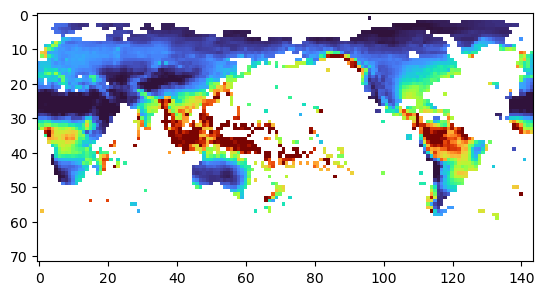

In [6]:
# Numpy-like computations can be made:

averaged_precip = x['precip'].mean(dim='time')
plt.imshow(averaged_precip,vmin=np.nanpercentile(averaged_precip,5),vmax=np.nanpercentile(averaged_precip,95),cmap='turbo')

In [7]:
# And you can convert the whole thing to an ND numpy array if you wish.

precip_array = x['precip'].to_numpy()
np.shape(precip_array)

(1356, 72, 144)

# Making NetCDFs

Suppose you have a pile of images that you need to make into a NetCDF for easier analysis.  This function takes a list of filenames and reads the data into a NetCDF, which you can then return and (optionally) save immediately.  It imagings that the datetime is encoded the filename and will construct a time dimension accordingly.  The datetime_format must be supplied correctly for this to work.  See [this page](https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior) for formatting guidelines.

In [8]:
def make_netcdf(fns,label='data',fn_out=None,datetime_format='%Y%m%d-%H%M%S',datetimes=[],crs=None):
    da = []
    for fn in fns:
        print(fn)
        d=rioxarray.open_rasterio(fn).squeeze(drop=True).to_dataset(name=label)
        da.append(d)
    formatted_datetimes = [pd.to_datetime(datetime.strptime(dt,datetime_format)) for dt in datetimes]
    da = xr.concat(da,dim=pd.Index(datetimes,name='time')) 
    if crs is not None:
        da.rio.write_crs(crs)
    if fn_out is not None:
        da.to_netcdf(fn_out,engine='netcdf4',encoding={label:{'zlib':True}})  
    return da

In [9]:
# We'll once again use Iowa State's NEXRAD mosaics.  Download a few sample images and store them in a nexrad directory:
# https://mesonet.agron.iastate.edu/docs/nexrad_mosaic/

fns = glob.glob('data/nexrad/*.png')
datetimes = [os.path.basename(fn)[4:-4] for fn in fns]
datetime_format = '%Y%m%d%H%M'
label = 'nexrad'
crs = 4326
fn_out = 'nexrad.nc'

make_netcdf(fns,label,fn_out,datetime_format,datetimes,crs)

data/nexrad\n0q_202304260000.png
data/nexrad\n0q_202304260005.png
data/nexrad\n0q_202304260010.png


ModuleNotFoundError: No module named 'netCDF4'

 ## Visualization of NetCDFs
 
There are several options for visualizaing NetCDFs in Python.  [GeoViews](https://geoviews.org/) is a particular favorite, but other options include [XrViz](https://levelup.gitconnected.com/xrviz-an-interactive-visualisation-interface-for-xarrays-9ecf8e325aa9) and [HoloViews](https://holoviews.org/) (for non-geographic data).  Other than [Panoply](https://www.giss.nasa.gov/tools/panoply/), other non-Python methods of visualization include [Ncview](http://meteora.ucsd.edu/~pierce/ncview_home_page.html) and [Godiva](https://www.unidata.ucar.edu/software/thredds/current/tds/reference/GodivaUsersGuide.html).

## Multidimensional data in ArcGIS

ArcGIS Pro also supports multidimensional datasets.  When loading, go to Add Data -> Multidimensional Raster Layer

Resources:
* Documentation: [Multidimensional raster data](https://pro.arcgis.com/en/pro-app/latest/help/data/imagery/an-overview-of-multidimensional-raster-data.htm)
* Video: [Multidimensional Analysis: Geoprocessing tools in ArcGIS Pro](https://youtu.be/afG704gTdOI)
* Video: [Create Multidimensional Raster Data Using a Single netCDF, GRIB, or HDR File](https://www.youtube.com/watch?v=sR0_aEU6brA)
* Video: [Create Multidimensional Raster Dta from Multiple NetCDF, GRID, or HDF Files](https://youtu.be/1ESpfo7du1I)
* Video: [Create Multidimensional Rasters from a Collection of Images](https://youtu.be/HFbTFTnsMWM)

# Parallelizing Processing

Computers generally have more than one core that allows processing to happen in parallel (many at once) rather than serially (one after another).  Python code that you write will generally run serially unless you take some special steps to code in parallel processing.  Let's look at two tools to speed up computation using parallelization: [scikit-image's apply_parallel](https://scikit-image.org/docs/stable/api/skimage.util.html#skimage.util.apply_parallel) and [joblib](https://joblib.readthedocs.io/en/latest/).  There are many more ways to do this, including the [multiprocessing](https://docs.python.org/3/library/multiprocessing.html) package and [Dask](https://www.dask.org/).

In [14]:
# How many cores do we have for processing?

import multiprocessing
multiprocessing.cpu_count()

16

In [15]:
# Or:

n_cores = os.cpu_count()
print(n_cores)

16


## Apply_parallel

In [16]:
import rasterio
import skimage
from skimage.util import apply_parallel

In [ ]:
# Let's load the Blacksburg DEM data

with rasterio.open('data/nasadem_blacksburg_area.tif') as src:
    image_array = src.read(1)
    cellsize = np.mean(src.res)

In [ ]:
# Some functions execute quickly over the whole raster.  Slope is near-instantaneous:

def slope(I,cellsize):
    gy,gx = np.gradient(I,cellsize)
    S = np.sqrt(gx**2 + gy**2)
    return S

S = slope(image_array,cellsize)

In [ ]:
# But some take more time, especially as neighborhood size increases

tic = time.time()

result = ndi.median_filter(image_array,51)

toc = time.time()
print(toc-tic)

In [ ]:
# By splitting the image and using apply_parallel, we can solve faster.
# How much faster depends on your calculations and optimizing your size and overlap

def my_func(I):
   return ndi.median_filter(I,51)

tic = time.time()
result2 = apply_parallel(my_func,image_array,600,100)      # Size and overlap
toc = time.time()
print(toc-tic)

# Joblib

There are many tools to parallelize tasks.  Any task in which each iteration is independent of the next can be parallelized.  We'll use [joblib](https://joblib.readthedocs.io/en/latest/) to do this, but many other packages exist, including [multiprocessing](https://docs.python.org/3/library/multiprocessing.html) in core Python.

In [17]:
from joblib import Parallel, delayed
from math import sqrt

In [ ]:
# The basic structure looks like this

k = 10000
result = Parallel(n_jobs=-1)(delayed(sqrt)(i**2) for i in range(k))    # n_jobs says how many cores to use. 
print(result[:10])                                                     # -1 is all of them.

In [ ]:
# Suppose we wanted to try several different window sizes for an operation and inspect the results.  If we did
# this serially, it would take a long time!  But by paralellizing the task we can cut that down significantly:

# Serial approach first:

tic = time.time()

windows = np.arange(3,22,3)
result = [ndi.median_filter(image_array,w) for w in windows]
    
toc = time.time()
print(toc-tic)

In [ ]:
# Now with joblib

tic = time.time()

windows = np.arange(3,22,3)
result2 = Parallel(n_jobs=-1)(delayed(ndi.median_filter)(image_array,w) for w in windows)

toc = time.time()
print(toc-tic)

## Processing multiple files

Suppose you have a pile of data you need to process. These might be making calculations as shown here, or processing
and writing out a result image.  Joblib can help here too:

In [27]:
fns = glob.glob('data/wget/*.png')

In [28]:
# This is a time-consuming nonsense calculation; sort the data, and pick out the 100th element.

def my_func(I):
    return np.sort(im.flatten())[100]

In [29]:
# Serially making a simple calculation

tic = time.time()

result = np.zeros(len(fns))
for i,fn in enumerate(fns):
    im = imageio.v2.imread(fn)
    result[i] = my_func(im)

toc = time.time()
print(toc-tic)

70.2325804233551


In [30]:
# And now with joblib.  Gains will be proportional to the amount of time spent processing vs IO
# (input-output calls to read and write data are necessarily sequential).  As a result, I'm specifying
# n_jobs=2 to avoid "stepping" on disk-writes.

tic = time.time()

results = Parallel(n_jobs=2)(delayed(my_func)(imageio.v2.imread(fn)) for fn in fns)

toc = time.time()
print(toc-tic)

48.831555128097534
